In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def sort_reset_date(df, col_d='WORK_DATE'):
    """ Sort and reset dataframes based on the date and time

    Args:
        df: dataframes containing column about the date
        col_d: date column of the dataframe, to be manipulated

    Returns:
        df: sorted dataframe with reset index
    """
    
    df.sort_values(by=col_d, inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    return df

In [3]:
def hour_rounder(df, col_t='DEB_TIME'):
    """ Floor down the time to the hour to merge on weather data

    Args:
        df: dataframe to be modified
        col_t: column to be used for floor the time

    Returns:
        df: updated dataframe with new time floored to the hour
    """

    df['TIME_HOUR'] = pd.to_datetime(df[col_t]).dt.floor('60min')
    
    return df

In [4]:
def delta_time_parade(df):
    """ Calculate time difference between parades and night show (if existing) and the time at each time slot

    Args:
        df: dataframe to be updated

    Returns:
        df: updated dataframe with new columns
    """
    
    day_duration = (23 - 9) * 60
    
    df['delta_p1'] = 0
    df['delta_p2'] = 0
    df['delta_ns'] = 0

    deb_list_1 = pd.to_datetime(df[~df['PARADE_1'].isna()]['DEB_TIME']).dt.time
    deb_list_2 = pd.to_datetime(df[~df['PARADE_2'].isna()]['DEB_TIME']).dt.time
    deb_list_ns = pd.to_datetime(df[~df['NIGHT_SHOW'].isna()]['DEB_TIME']).dt.time

    parade_1_list = pd.to_datetime(df[~df['PARADE_1'].isna()]['PARADE_1'], format='%H:%M:%S').dt.time
    parade_2_list = pd.to_datetime(df[~df['PARADE_2'].isna()]['PARADE_2'], format='%H:%M:%S').dt.time
    parade_night_show = pd.to_datetime(df[~df['NIGHT_SHOW'].isna()]['NIGHT_SHOW'], format='%H:%M:%S').dt.time

    # df.loc[~df['PARADE_1'].isna(), 'delta_p1'] = [1-((abs(((c_d.hour - c_tt.hour)*60 + (c_d.minute - c_tt.minute))))/day_duration) for c_d, c_tt in zip(deb_list_1, parade_1_list)]

    df.loc[~df['PARADE_1'].isna(), 'delta_p1'] = [1-((abs(((c_d.hour - c_tt.hour)*60 + (c_d.minute - c_tt.minute))))/day_duration) for c_d, c_tt in zip(deb_list_1, parade_1_list)]
    df.loc[~df['PARADE_2'].isna(), 'delta_p2'] = [1-((abs(((c_d.hour - c_tt.hour)*60 + (c_d.minute - c_tt.minute))))/day_duration) for c_d, c_tt in zip(deb_list_2, parade_2_list)]
    df.loc[~df['NIGHT_SHOW'].isna(), 'delta_ns'] = [1-((abs(((c_d.hour - c_tt.hour)*60 + (c_d.minute - c_tt.minute))))/day_duration) for c_d, c_tt in zip(deb_list_ns, parade_night_show)]

    return df

In [5]:
def load_data():
    """ Load all the attendance, weather and waiting data

    Returns:
        attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data: All dataframes returned by the function
    """
    
    print('Data Loading...')
    attendance = pd.read_csv(r'data/attendance.csv')
    entity_schedule = pd.read_csv(r'data/entity_schedule.csv')
    # glossary = pd.read_excel(r'data/glossary.xlsx')
    link_attraction = pd.read_csv(r'data/link_attraction_park.csv', sep=';')
    parade_night_show = pd.read_excel(r'data/parade_night_show.xlsx')
    waiting_times = pd.read_csv(r'data/waiting_times.csv')
    weather_data = pd.read_csv(r'data/weather_data.csv')

    parade_night_show.drop(columns=['Unnamed: 0'], inplace=True)
    print('Data Loaded!')

    return attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data

In [6]:
def preprocessing_data(attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data):
    """ Basic preprocessing and data clearning to allow merging

    Args:
        attendance: Attendance dataframe containing attendance per day
        entity_schedule: Dataframe containing maintenance data
        link_attraction: Dataframe linking attractions to respective parks
        parade_night_show: Dataframe containing planned night shows and parades for the park
        waiting_times: Dataframe containing waiting times
        weather_data: Weather dataframe

    Returns:
        waiting_times, attendance, entity_schedule_pa, parade_night_show, weather_data: Preprocessed and cleaned dataframes ready for merging
    """
    print('Data Preprocessing...')
    attendance = attendance[attendance['FACILITY_NAME'] == 'PortAventura World']
    lst_attr = link_attraction[link_attraction['PARK'] == 'PortAventura World']['ATTRACTION']
    entity_schedule_pa = entity_schedule[entity_schedule['ENTITY_DESCRIPTION_SHORT'].isin(lst_attr)]
    waiting_times = waiting_times[waiting_times['ENTITY_DESCRIPTION_SHORT'].isin(lst_attr)]
    attendance = attendance[attendance['attendance']>=0]
    
    # Sort Dates and reset index
    attendance = sort_reset_date(attendance, 'USAGE_DATE')
    entity_schedule_pa = sort_reset_date(entity_schedule_pa, 'DEB_TIME')
    parade_night_show = sort_reset_date(parade_night_show, 'WORK_DATE')
    waiting_times = sort_reset_date(waiting_times, 'DEB_TIME')
    weather_data = sort_reset_date(weather_data, 'dt_iso')

    # Delete columns and some preprocessing
    weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'].str.replace(" +0000 UTC", "", regex=False), errors='coerce', format='%Y-%m-%d %H:%M:%S')
    cols_del = ['city_name', 'lat', 'lon', 'weather_id', 'visibility', 'sea_level', 'grnd_level', 'wind_gust', 'snow_3h']
    weather_data.drop(columns=cols_del, inplace=True)
    weather_data.fillna(0, inplace=True)
    attendance.rename(columns={'USAGE_DATE': 'WORK_DATE'}, inplace=True)
    # weather_data.rename(columns={'dt_iso': 'TIME_HOUR'}, inplace=True)

    attendance['WORK_DATE'] = pd.to_datetime(attendance['WORK_DATE'])
    waiting_times['WORK_DATE'] = pd.to_datetime(waiting_times['WORK_DATE'])
    parade_night_show['WORK_DATE'] = pd.to_datetime(parade_night_show['WORK_DATE'])

    weather_data = hour_rounder(weather_data, col_t='dt_iso')
    waiting_times = hour_rounder(waiting_times, col_t='DEB_TIME')
    entity_schedule_pa = hour_rounder(entity_schedule_pa, col_t='DEB_TIME')
    print('Data Preprocessed!')
    
    return waiting_times, attendance, entity_schedule_pa, parade_night_show, weather_data

In [7]:
def merge_data(waiting_times, attendance, entity_schedule_pa, parade_night_show, weather_data):
    """Merging dataframes into one final dataframe for prediction

    Args:
        waiting_times: Dataframe containing waiting times
        attendance: Attendance dataframe containing attendance per day
        entity_schedule_pa: Dataframe containing maintenance data
        parade_night_show: Dataframe containing planned night shows and parades for the park
        weather_data: Weather dataframe

    Returns:
        df_m: Merged dataframe
    """
    
    print('Merging Data...')
    # Merge the dataframes
    df_m = waiting_times.merge(attendance[['WORK_DATE', 'attendance']], how='left', on='WORK_DATE')
    df_m = df_m.merge(entity_schedule_pa[['TIME_HOUR', 'ENTITY_DESCRIPTION_SHORT', 'REF_CLOSING_DESCRIPTION', 'ENTITY_TYPE', 'UPDATE_TIME']], how='left', on=['TIME_HOUR', 'ENTITY_DESCRIPTION_SHORT'])
    df_m = df_m.merge(parade_night_show, how='left', on='WORK_DATE')
    df_m = df_m.merge(weather_data, how='left', on='TIME_HOUR')
    print('Data Merged!')
    
    return df_m 

In [8]:
def create_df():
    """ Function combining all loading, preprocessing and merging functions

    Returns:
        df_m: Merged and finalized dataframe
    """
    
    attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data = load_data()
    waiting_times, attendance, entity_schedule_pa, parade_night_show, weather_data = preprocessing_data(attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data)
    df_m = merge_data(waiting_times, attendance, entity_schedule_pa, parade_night_show, weather_data)
    df_m = delta_time_parade(df_m)
    
    # cols_del = ['dt', 'dt_iso', 'timezone', 'NIGHT_SHOW', 'PARADE_1', 'PARADE_2', 'TIME_HOUR', 'DEB_TIME_HOUR']
    # df_m.drop(columns=cols_del, inplace=True)
    
    print('Dataframe Finalized!')

    return df_m

In [9]:
attendance, entity_schedule, link_attraction, parade_night_show, waiting_times, weather_data = load_data()

Data Loading...
Data Loaded!


In [10]:
weather_data["dt_iso"] = pd.to_datetime(weather_data['dt_iso'].str.replace(" +0000 UTC", "", regex=False), errors='coerce', format='%Y-%m-%d %H:%M:%S')

In [46]:
attendance["month_year"] = pd.to_datetime(attendance['USAGE_DATE']).dt.to_period('M')
attendance["week_year"] = pd.to_datetime(attendance['USAGE_DATE']).dt.to_period('W')
attendance["year"] = pd.to_datetime(attendance['USAGE_DATE']).dt.to_period('Y')

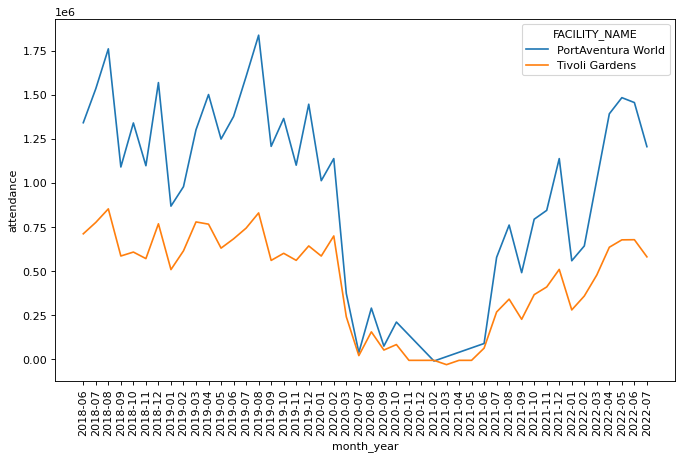

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
df_monthly_attendance = attendance.groupby(["month_year", "FACILITY_NAME"]).attendance.sum().reset_index()
df_monthly_attendance["month_year"] = df_monthly_attendance["month_year"].astype(str)

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi= 80)
sns.lineplot(x="month_year", y="attendance", hue='FACILITY_NAME', data=df_monthly_attendance, ax=ax)
ax.tick_params(axis='x', rotation=90)

In [236]:
weather_data["month_year"] = pd.to_datetime(weather_data["dt_iso"]).dt.to_period("M")
df_temp = weather_data[(weather_data["month_year"]>= "2018-06") & (weather_data["month_year"]<= "2022-07")].groupby("month_year")["temp"].mean().reset_index()
df_temp.month_year = df_temp.month_year.astype(str)

<AxesSubplot:xlabel='month_year', ylabel='temp'>

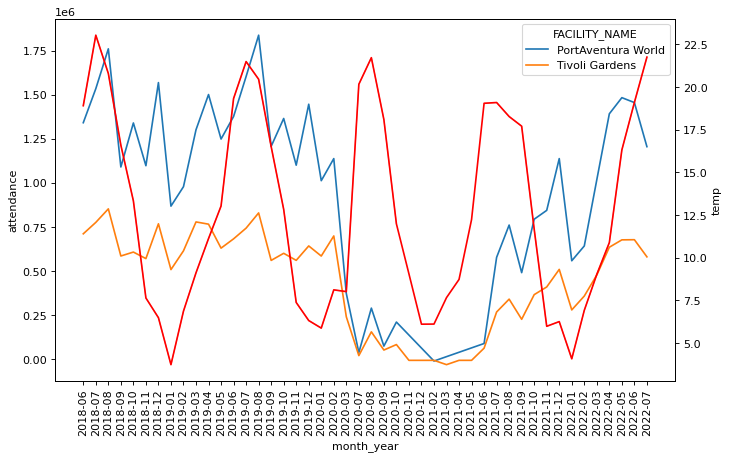

In [245]:
df_monthly_attendance = df_monthly_attendance.merge(df_temp, on="month_year")
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi= 80)
sns.lineplot(x="month_year", y="attendance", hue='FACILITY_NAME', data=df_monthly_attendance, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax2 =ax.twinx()
sns.lineplot(x="month_year", y="temp", data=df_monthly_attendance,color='r', ax=ax2)

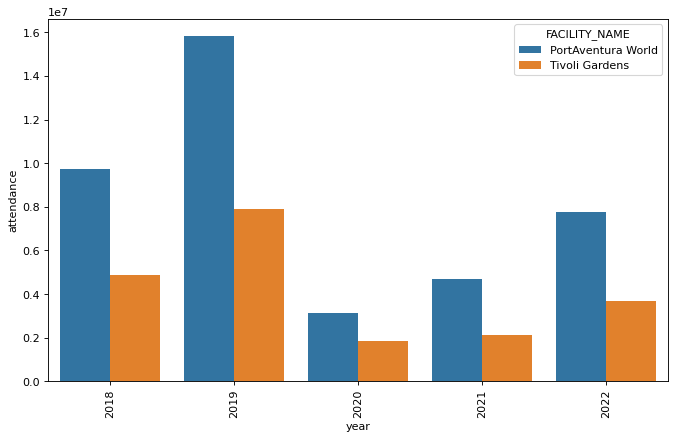

In [54]:
df_yearly_attendance = attendance.groupby(["year", "FACILITY_NAME"]).attendance.sum().reset_index()

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi= 80)
sns.barplot(x="year", y="attendance", hue='FACILITY_NAME', data=df_yearly_attendance, ax=ax)
ax.tick_params(axis='x', rotation=90)

In [82]:
entity_schedule["year"] = pd.to_datetime(entity_schedule["WORK_DATE"]).dt.to_period("Y")
df_schedule = entity_schedule[(~entity_schedule["REF_CLOSING_DESCRIPTION"].isna())]
link_attraction.rename(columns={"ATTRACTION":"ENTITY_DESCRIPTION_SHORT"}, inplace=True)
df_schedule = df_schedule.merge(link_attraction, on="ENTITY_DESCRIPTION_SHORT")
df_schedule.head()

,REF_CLOSING_DESCRIPTION,ENTITY_DESCRIPTION_SHORT,ENTITY_TYPE,DEB_TIME,FIN_TIME,UPDATE_TIME,WORK_DATE,year,PARK
0,Fermeture Réhab,Top Spin,ATTR,2019-04-07 23:59:00.000,2019-04-07 23:59:00.000,2019-04-08 07:40:04.000,2019-04-07,2019,Tivoli Gardens
1,Fermeture Réhab,Top Spin,ATTR,2019-08-28 23:59:00.000,2019-08-28 23:59:00.000,2019-08-29 09:04:03.000,2019-08-28,2019,Tivoli Gardens
2,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-11 23:59:00.000,2022-08-11 23:59:00.000,2022-08-12 10:08:16.000,2022-08-11,2022,Tivoli Gardens
3,Fermeture Réhab,Top Spin,ATTR,2020-01-19 23:59:00.000,2020-01-19 23:59:00.000,2020-01-20 07:43:14.000,2020-01-19,2020,Tivoli Gardens
4,Fermeture Réhab,Top Spin,ATTR,2019-07-15 23:59:00.000,2019-07-15 23:59:00.000,2019-07-16 07:42:07.000,2019-07-15,2019,Tivoli Gardens


In [136]:
df_schedule[df_schedule["ENTITY_DESCRIPTION_SHORT"] == "Spiral Slide"]

,REF_CLOSING_DESCRIPTION,ENTITY_DESCRIPTION_SHORT,ENTITY_TYPE,DEB_TIME,FIN_TIME,UPDATE_TIME,WORK_DATE,year,PARK
4427,Fermeture Réhab,Spiral Slide,ATTR,2019-05-15 23:59:00.000,2019-05-15 23:59:00.000,2019-05-16 07:43:32.000,2019-05-15,2019,PortAventura World
4428,Fermeture Réhab,Spiral Slide,ATTR,2019-05-14 23:59:00.000,2019-05-14 23:59:00.000,2019-05-15 07:51:00.000,2019-05-14,2019,PortAventura World
4429,Fermeture Réhab,Spiral Slide,ATTR,2019-05-17 23:59:00.000,2019-05-17 23:59:00.000,2019-05-18 07:40:31.000,2019-05-17,2019,PortAventura World
4430,Fermeture Réhab,Spiral Slide,ATTR,2019-05-16 23:59:00.000,2019-05-16 23:59:00.000,2019-05-17 07:40:55.000,2019-05-16,2019,PortAventura World
4431,Fermeture Réhab,Spiral Slide,ATTR,2019-05-13 23:59:00.000,2019-05-13 23:59:00.000,2019-05-14 07:41:20.000,2019-05-13,2019,PortAventura World


<AxesSubplot:>

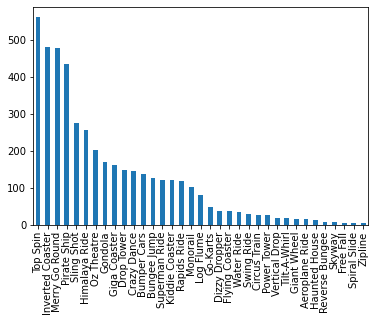

In [81]:
df_schedule["ENTITY_DESCRIPTION_SHORT"].value_counts().plot(kind="bar")

In [119]:
df_closings_yearly = df_schedule.groupby(["year", "PARK", "REF_CLOSING_DESCRIPTION","ENTITY_DESCRIPTION_SHORT"]).agg(**{'count': ('ENTITY_DESCRIPTION_SHORT', 'count')}).reset_index()
df_average_closings = df_closings_yearly.groupby(["year", "PARK", "REF_CLOSING_DESCRIPTION"])["count"].mean().reset_index()
df_average_closings.rename(columns={"count":"average"}, inplace=True)
df_average_closings

,year,PARK,REF_CLOSING_DESCRIPTION,average
0,2018,PortAventura World,Fermeture Opérationnelle,68.250000
1,2018,PortAventura World,Fermeture Réhab,47.777778
2,2018,Tivoli Gardens,Fermeture Opérationnelle,13.333333
3,2018,Tivoli Gardens,Fermeture Réhab,23.857143
4,2019,PortAventura World,Fermeture Opérationnelle,88.250000
5,2019,PortAventura World,Fermeture Réhab,36.250000
6,2019,Tivoli Gardens,Fermeture Opérationnelle,14.000000
7,2019,Tivoli Gardens,Fermeture Réhab,114.800000
8,2020,PortAventura World,Fermeture Réhab,31.666667
9,2020,Tivoli Gardens,Fermeture Réhab,56.333333


In [133]:
link_attraction.rename(columns={"ATTRACTION":"ENTITY_DESCRIPTION_SHORT"}, inplace=True)
df_num_attraction = entity_schedule[entity_schedule["ENTITY_TYPE"] == "ATTR"]
df_num_attraction = df_num_attraction.merge(link_attraction, on="ENTITY_DESCRIPTION_SHORT")
df_num_attraction = df_num_attraction.groupby(["year", "PARK"]).agg(**{'unique_count': ('ENTITY_DESCRIPTION_SHORT', 'nunique')}).reset_index()
df_num_attraction

,year,PARK,unique_count
0,2018,PortAventura World,25
1,2018,Tivoli Gardens,12
2,2019,PortAventura World,25
3,2019,Tivoli Gardens,12
4,2020,PortAventura World,25
5,2020,Tivoli Gardens,12
6,2022,PortAventura World,26
7,2022,Tivoli Gardens,13


Text(0.5, 1.0, 'Total number of attractions')

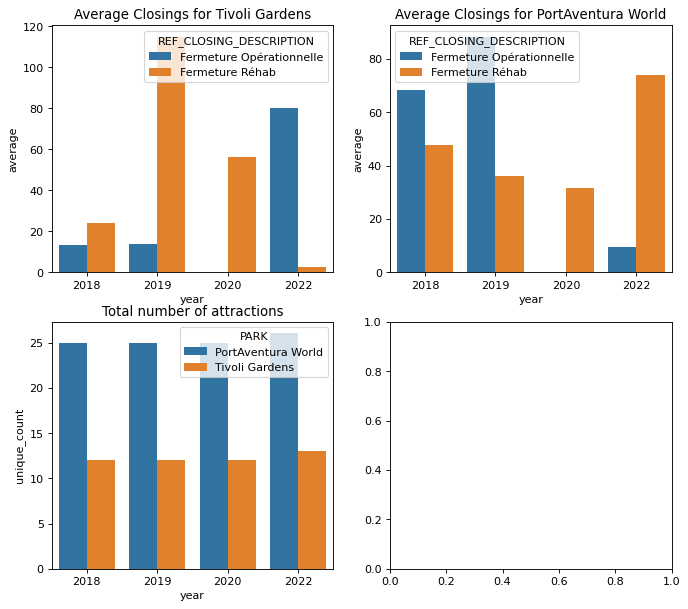

In [140]:
fig, ax = plt.subplots(2,2, figsize=(10,9), dpi= 80)
sns.barplot(x="year", y="average", hue="REF_CLOSING_DESCRIPTION",
data=df_average_closings[df_average_closings["PARK"] == "Tivoli Gardens"], ax=ax[0, 0])
ax[0,0].set_title("Average Closings for Tivoli Gardens")
sns.barplot(x="year", y="average", hue="REF_CLOSING_DESCRIPTION",
data=df_average_closings[df_average_closings["PARK"] == "PortAventura World"], ax=ax[0, 1])
ax[0,1].set_title("Average Closings for PortAventura World")
sns.barplot(x="year", y="unique_count", hue="PARK", data=df_num_attraction, ax=ax[1, 0])
ax[1,0].set_title("Total number of attractions")

Text(0.5, 1.0, 'Average Closings for PortAventura World')

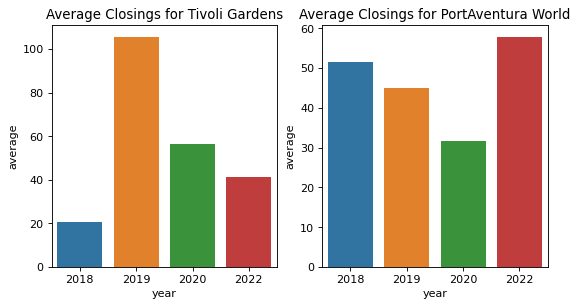

In [252]:
df_closings_yearly = df_schedule.groupby(["year", "PARK", "REF_CLOSING_DESCRIPTION","ENTITY_DESCRIPTION_SHORT"]).agg(**{'count': ('ENTITY_DESCRIPTION_SHORT', 'count')}).reset_index()
df_average_closings = df_closings_yearly.groupby(["year", "PARK"])["count"].mean().reset_index()
df_average_closings.rename(columns={"count":"average"}, inplace=True)

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi= 80)
sns.barplot(x="year", y="average", data=df_average_closings[df_average_closings["PARK"] == "Tivoli Gardens"], ax=ax[0])
ax[0].set_title("Average Closings for Tivoli Gardens")
sns.barplot(x="year", y="average", data=df_average_closings[df_average_closings["PARK"] == "PortAventura World"], ax=ax[1])
ax[1].set_title("Average Closings for PortAventura World")

In [77]:
entity_schedule[(~entity_schedule["REF_CLOSING_DESCRIPTION"].isna()) & (entity_schedule["ENTITY_DESCRIPTION_SHORT"] == "Top Spin")]

,REF_CLOSING_DESCRIPTION,ENTITY_DESCRIPTION_SHORT,ENTITY_TYPE,DEB_TIME,FIN_TIME,UPDATE_TIME,WORK_DATE
5,Fermeture Réhab,Top Spin,ATTR,2019-04-07 23:59:00.000,2019-04-07 23:59:00.000,2019-04-08 07:40:04.000,2019-04-07
30,Fermeture Réhab,Top Spin,ATTR,2019-08-28 23:59:00.000,2019-08-28 23:59:00.000,2019-08-29 09:04:03.000,2019-08-28
46,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-11 23:59:00.000,2022-08-11 23:59:00.000,2022-08-12 10:08:16.000,2022-08-11
61,Fermeture Réhab,Top Spin,ATTR,2020-01-19 23:59:00.000,2020-01-19 23:59:00.000,2020-01-20 07:43:14.000,2020-01-19
116,Fermeture Réhab,Top Spin,ATTR,2019-07-15 23:59:00.000,2019-07-15 23:59:00.000,2019-07-16 07:42:07.000,2019-07-15
...,...,...,...,...,...,...,...
38068,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-22 23:59:00.000,2022-08-22 23:59:00.000,2022-08-23 09:02:45.000,2022-08-22
38191,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-20 23:59:00.000,2022-08-20 23:59:00.000,2022-08-21 09:17:00.000,2022-08-20
38213,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-19 23:59:00.000,2022-08-19 23:59:00.000,2022-08-20 07:37:11.000,2022-08-19
38263,Fermeture Opérationnelle,Top Spin,ATTR,2022-08-18 23:59:00.000,2022-08-18 23:59:00.000,2022-08-19 07:56:40.000,2022-08-18


In [55]:
waiting_times.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT
0,2018-01-01,2018-01-01 21:00:00.000,21,2018-01-01 21:15:00.000,Roller Coaster,0,2.0,0.0,0.000,0.00,0,0,0,2.0
1,2018-01-01,2018-01-01 19:30:00.000,19,2018-01-01 19:45:00.000,Bumper Cars,5,18.0,148.0,254.749,254.75,15,15,0,18.0
2,2018-01-01,2018-01-01 22:30:00.000,22,2018-01-01 22:45:00.000,Rapids Ride,0,1.0,0.0,0.000,0.00,0,0,0,2.0
3,2018-01-01,2018-01-01 12:45:00.000,12,2018-01-01 13:00:00.000,Crazy Dance,5,1.0,46.0,250.001,250.00,15,15,0,1.0
4,2018-01-01,2018-01-01 17:00:00.000,17,2018-01-01 17:15:00.000,Skyway,5,15.0,92.0,211.500,198.25,15,15,0,16.0


In [57]:
len(waiting_times["ENTITY_DESCRIPTION_SHORT"].value_counts())

39

In [61]:
link_attraction.rename(columns={"ATTRACTION":"ENTITY_DESCRIPTION_SHORT"}, inplace=True)
df_waiting_times_per_park = waiting_times.merge(link_attraction, on="ENTITY_DESCRIPTION_SHORT")

In [142]:
df_waiting_times_per_park.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT,PARK
0,2018-01-01,2018-01-01 21:00:00.000,21,2018-01-01 21:15:00.000,Roller Coaster,0,2.0,0.0,0.0,0.0,0,0,0,2.0,PortAventura World
1,2018-01-01,2018-01-01 15:00:00.000,15,2018-01-01 15:15:00.000,Roller Coaster,20,2.0,51.0,75.0,75.0,15,15,0,2.0,PortAventura World
2,2018-01-01,2018-01-01 20:15:00.000,20,2018-01-01 20:30:00.000,Roller Coaster,0,2.0,0.0,0.0,0.0,0,0,0,2.0,PortAventura World
3,2018-01-01,2018-01-01 11:45:00.000,11,2018-01-01 12:00:00.000,Roller Coaster,50,2.0,54.0,75.0,75.0,15,15,0,2.0,PortAventura World
4,2018-01-01,2018-01-01 17:00:00.000,17,2018-01-01 17:15:00.000,Roller Coaster,20,2.0,29.0,75.0,75.0,15,15,0,2.0,PortAventura World


In [143]:
df_waiting_times_per_park["month"] = pd.to_datetime(df_waiting_times_per_park["WORK_DATE"]).dt.month
df_waiting_times_per_park["year_month"] = pd.to_datetime(df_waiting_times_per_park["WORK_DATE"]).dt.to_period("M")

Text(0.5, 1.0, 'Average waiting time per hour')

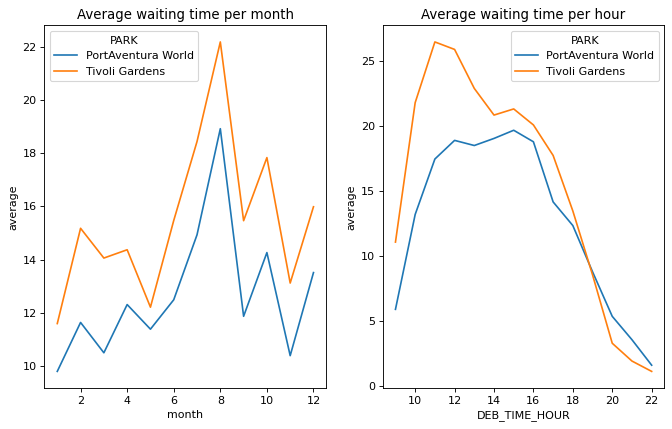

In [170]:
df_monthly_wait = df_waiting_times_per_park.groupby(["month","PARK"]).agg(**{'average': ('WAIT_TIME_MAX', 'mean'),
"max":('WAIT_TIME_MAX', 'max'), "min":('WAIT_TIME_MAX', 'min')}).reset_index()
df_hourly_wait = df_waiting_times_per_park.groupby(["DEB_TIME_HOUR","PARK"]).agg(**{'average': ('WAIT_TIME_MAX', 'mean'),
"max":('WAIT_TIME_MAX', 'max'), "min":('WAIT_TIME_MAX', 'min')}).reset_index()
df_year_month_wait = df_waiting_times_per_park.groupby(["year_month","PARK"]).agg(**{'average': ('WAIT_TIME_MAX', 'mean'),
"max":('WAIT_TIME_MAX', 'max'), "min":('WAIT_TIME_MAX', 'min')}).reset_index()
df_year_month_wait["year_month"] = df_year_month_wait["year_month"].astype(str)

fig, ax = plt.subplots(1,2, figsize=(10,6), dpi= 80)
sns.lineplot(x="month", y="average", hue="PARK", data=df_monthly_wait, ax=ax[0])
ax[0].set_title("Average waiting time per month")
sns.lineplot(x="DEB_TIME_HOUR", y="average", hue="PARK", data=df_hourly_wait, ax=ax[1])
ax[1].set_title("Average waiting time per hour")


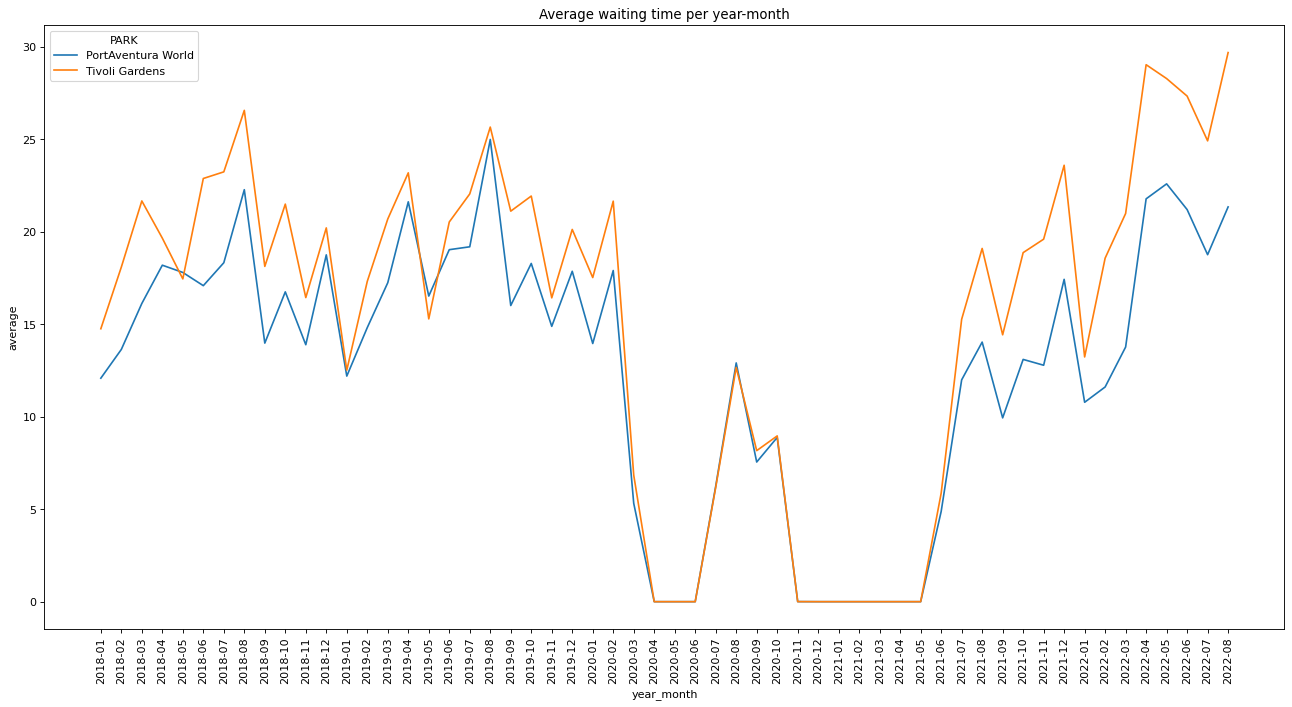

In [166]:
fig, ax = plt.subplots(1,1, figsize=(20,10), dpi= 80)
sns.lineplot(x="year_month", y="average", hue="PARK", data=df_year_month_wait, ax=ax)
ax.set_title("Average waiting time per year-month")
ax.tick_params(axis='x', rotation=90)

Text(0.5, 1.0, 'Total Capacity')

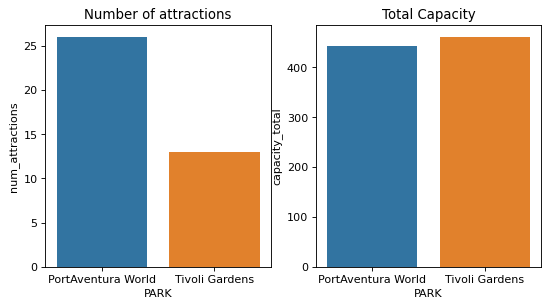

In [211]:
df_attraction_capac = df_waiting_times_per_park[["PARK", "ENTITY_DESCRIPTION_SHORT", "NB_MAX_UNIT"]].drop_duplicates()
df_attraction_capac = df_attraction_capac.groupby("PARK").agg(**{"num_attractions": ("ENTITY_DESCRIPTION_SHORT","nunique"),
"capacity_total": ("NB_MAX_UNIT","sum")}).reset_index()
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi= 80)
sns.barplot(x="PARK", y="num_attractions", data=df_attraction_capac, ax=ax[0])
ax[0].set_title("Number of attractions")
sns.barplot(x="PARK", y="capacity_total", data=df_attraction_capac, ax=ax[1])
ax[1].set_title("Total Capacity")

Text(0.5, 1.0, 'Average daily available capacity per month')

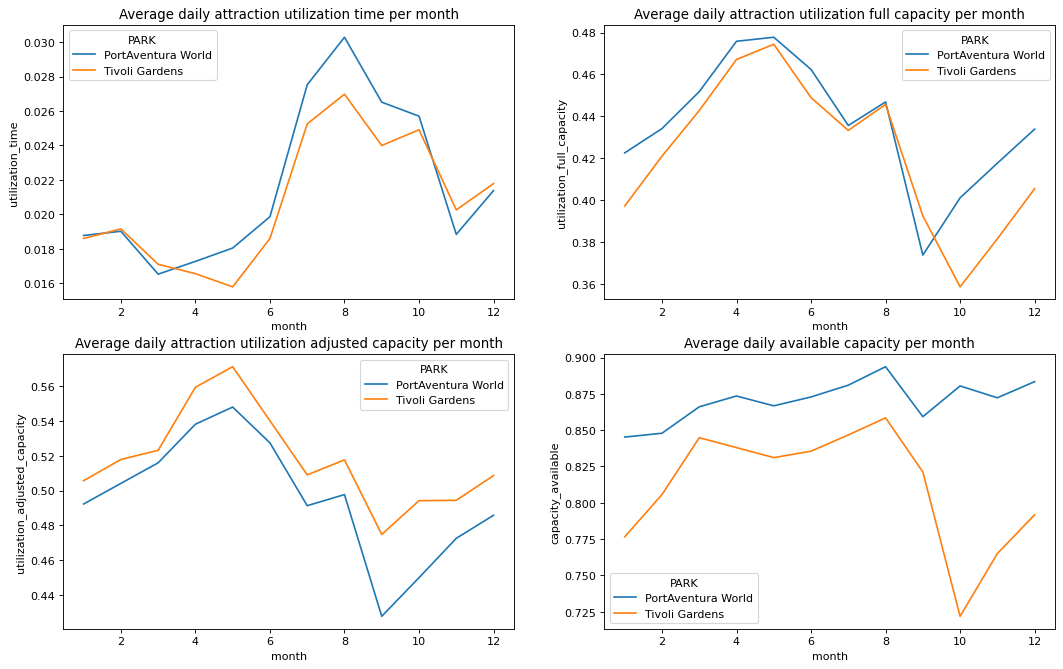

In [199]:
df_capacity = df_waiting_times_per_park.groupby(["WORK_DATE", "DEB_TIME_HOUR", "month", "PARK"]).agg(**{'UP_TIME': ('UP_TIME', 'sum'),
'CAPACITY': ('CAPACITY', 'sum'), 'ADJUST_CAPACITY': ('ADJUST_CAPACITY', 'sum'),
'GUEST_CARRIED': ('GUEST_CARRIED', 'sum'), "num_attractions":("ENTITY_DESCRIPTION_SHORT", "nunique")}).reset_index()
df_capacity["full_time"] = df_capacity["num_attractions"]*24*60
df_capacity["utilization_time"] = df_capacity["UP_TIME"]/df_capacity["full_time"]
df_capacity["utilization_full_capacity"] = df_capacity["GUEST_CARRIED"]/df_capacity["CAPACITY"]
df_capacity["utilization_adjusted_capacity"] = df_capacity["GUEST_CARRIED"]/df_capacity["ADJUST_CAPACITY"]
df_capacity["capacity_available"] = df_capacity["ADJUST_CAPACITY"]/df_capacity["CAPACITY"]

df_monthly_capacity = df_capacity.groupby(["month", "PARK"])[["utilization_time",
"utilization_full_capacity", "utilization_adjusted_capacity", "capacity_available"]].mean().reset_index()

fig, ax = plt.subplots(2,2, figsize=(16,10), dpi= 80)
sns.lineplot(x="month", y="utilization_time", hue="PARK", data=df_monthly_capacity, ax=ax[0, 0])
ax[0, 0].set_title("Average daily attraction utilization time per month")
sns.lineplot(x="month", y="utilization_full_capacity", hue="PARK", data=df_monthly_capacity, ax=ax[0, 1])
ax[0, 1].set_title("Average daily attraction utilization full capacity per month")
sns.lineplot(x="month", y="utilization_adjusted_capacity", hue="PARK", data=df_monthly_capacity, ax=ax[1, 0])
ax[1, 0].set_title("Average daily attraction utilization adjusted capacity per month")
sns.lineplot(x="month", y="capacity_available", hue="PARK", data=df_monthly_capacity, ax=ax[1, 1])
ax[1, 1].set_title("Average daily available capacity per month")


In [191]:
df_monthly_capacity[df_monthly_capacity["PARK"] == "PortAventura World"]

,month,PARK,utilization_time,utilization_full_capacity,utilization_adjusted_capacity
0,1,PortAventura World,0.018775,NaN,NaN
2,2,PortAventura World,0.019019,NaN,NaN
4,3,PortAventura World,0.016530,NaN,NaN
6,4,PortAventura World,0.017271,NaN,NaN
8,5,PortAventura World,0.018046,2.329703,1.946945
10,6,PortAventura World,0.019865,2.532018,2.156021
12,7,PortAventura World,0.027524,NaN,NaN
14,8,PortAventura World,0.030282,2.727800,2.388008
16,9,PortAventura World,0.026513,NaN,NaN
18,10,PortAventura World,0.025700,7.138012,5.779340
